# Линейная регрессия

In [2]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

np.set_printoptions(suppress=True)

In [3]:
def read_data(path="boston.csv"):
    with open(path) as f:
        my_lines = f.readlines()
        columns = my_lines[14].split(',')
    
    columns[-1] = columns[-1].rstrip()
    df = pd.DataFrame(np.genfromtxt(path, delimiter=",", skip_header=15))
    df.columns = columns
    
    df = df.sample(frac=1, random_state=42)
    X = df.drop(['medv'], axis=1)
    y = df.medv
    return X, y

In [4]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

In [5]:
x, y = read_data()

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [6]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return np.mean((y_predicted - y_true) ** 2)

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    y_mean_sample = np.mean(y_true)
    v = sum([(y_mean_sample - true_value) ** 2 for true_value in y_true])
    u = sum([(hypothesis - true_value) ** 2 for hypothesis, true_value in zip(y_predicted, y_true)])
    
    return 1 - u / v

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [7]:
class NormalLR:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
    
    def fit(self, X:np.ndarray, y:np.ndarray): 
        if self.fit_intercept:
            X = np.hstack((X, np.ones(shape=(X.shape[0], 1))))
            
        self.w = np.linalg.pinv(X) @ y
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        if self.fit_intercept:
            X = np.hstack((X, np.ones(shape=(X.shape[0], 1))))
            
        return X @ self.w

In [8]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [9]:
regr = NormalLR(fit_intercept=True)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.010012519546406909, R2: 0.998077045044391


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

Помимо изначального функционала будем считать mse на каждой итерации.

Считаем, что $|x|' = sign(x)$, причем сглаженный (чтобы не было разрывов $\Rightarrow$ чтобы MSE всегда невозрастала)

Формулы (по мотивам sklearn):

**Loss:**

$$L(w) = \frac{1}{2 n} ||Xw - y||^2_2 + \alpha ||w||_1 = \frac{1}{2n}(Xw - y)^T(Xw - y)+ \alpha ||w||_1 = \frac{1}{2n}(w^T X^T - y^T)(Xw - y)+ \alpha ||w||_1 = \frac{1}{2n}(w^T X^TXw - w^TX^Ty - y^TXw + y^Ty)+ \alpha ||w||_1 = \frac{1}{2n}(w^T X^TXw - 2w^TX^Ty + y^Ty)+ \alpha ||w||_1$$

**Градиент:**

$$\frac{\partial L}{\partial w} = \frac{1}{2n}((X^TX + (X^TX)^T)w - 2X^Ty) + \alpha \; sign(w) = \frac{1}{n} (X^TXw - X^Ty) + \alpha \; sign(w) = \frac{1}{n} X^T(Xw - y) + \alpha  \; sign(w) = \frac{1}{n} X^T(y_{pred} - y) + \alpha  \; sign(w)$$

In [10]:
class GradientLR:
    
    def __init__(self, alpha:float, iterations=10000, l=0., fit_intercept=True):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.fit_intercept = fit_intercept
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        n_rows, n_col = X.shape
        
        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n_rows, 1))))
        
        self.w = np.zeros(n_col + 1 if self.fit_intercept else n_col)
        self.losses = []
        
        for _ in range(self.iterations):
            y_pred = self.predict(X)
            self.losses.append(mse(y, y_pred))

            self.w -= self.alpha * (self._calc_gradient_l1() + (self._calc_gradient(X_train, y, y_pred)) / n_rows)

    def predict(self, X:np.ndarray):
        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((X.shape[0], 1))))
            
        return X_train @ self.w
    
    def get_losses(self):
        return self.losses
    
    def _calc_gradient(self, X, y, y_pred):
        grad = X.T @ (y_pred - y)
        return grad
    
    def _calc_gradient_l1(self):
        grad_l1 = GradientLR.soft_sign(self.w)
        
        if self.fit_intercept:
            grad_l1[-1] = 0 # bias в регуляризационные слагаемое не входит.
            
        return grad_l1 * self.l
    
    @staticmethod
    def soft_sign(xs, eps=1e-7):
        return np.array(list(map(lambda x: np.sign(x) if abs(x) > eps else x / eps, xs)))

In [10]:
def build_plot(X_train, y_train, X_test, y_test, alpha=0.1, range_start=0.0, range_end=0.002, step=0.00002):
    xs = np.arange(range_start, range_end, step)
    errors = []
    for x in xs:
        regr = GradientLR(alpha, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [11]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

scaler = StandardScaler()
scaler.fit(X_train)

X_test = scaler.transform(X_test)
X_train = scaler.transform(X_train)

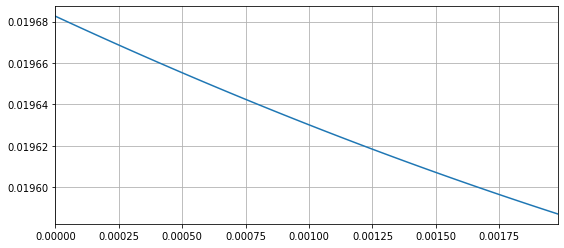

In [12]:
build_plot(X_train, y_train, X_val, y_val)

Посмотрим на loss в зависимости от номера итерации:

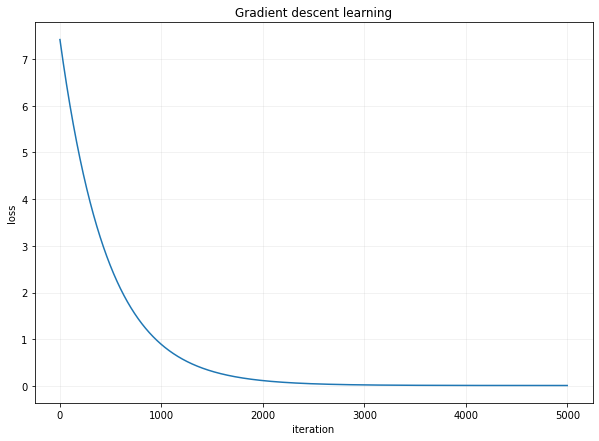

In [13]:
regr = GradientLR(0.001, iterations=5000)
regr.fit(X_train, y_train)
l = regr.get_losses()

plt.figure(figsize=(10, 7))

plt.plot(l)
plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)

plt.show()

Всё как и должно быть.

In [11]:
regr = GradientLR(0.1, iterations=1000, fit_intercept=False)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 1.860187846574164, R2: 0.6427415276090844


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [15]:
X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [16]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 22266311.080837082, R2: 0.6872797475661027


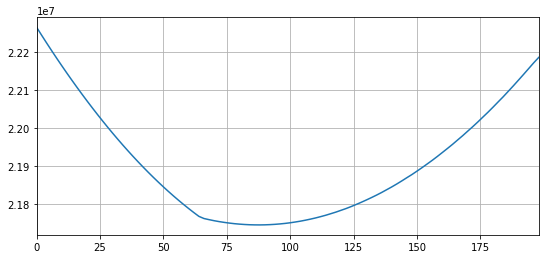

In [17]:
build_plot(X_train, y_train, X_val, y_val, alpha=0.01, range_start=0.0, range_end=200, step=2)

In [32]:
regr = GradientLR(0.001, iterations=3000)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 22295903.715824608, R2: 0.6868641324132428


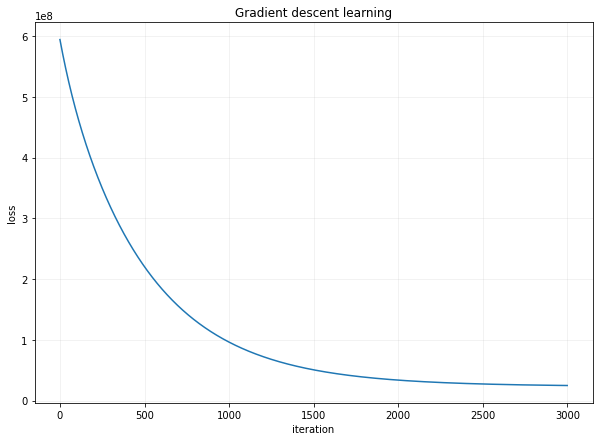

In [33]:
l = regr.get_losses()

plt.figure(figsize=(10, 7))

plt.plot(l)
plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)

plt.show()

### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

Веса признаков линейной регрессии, решенной методом градиентного спуска:

In [34]:
sorted(list(zip(regr.w, [*X.columns, *['bias weight']])), key=lambda x: abs(x[0]), reverse=True)

[(21386.88118824673, 'bias weight'),
 (-3303.555737657299, 'lstat'),
 (3272.006346445369, 'rm'),
 (-1793.837051133241, 'dis'),
 (-1693.8445181109014, 'ptratio'),
 (821.7552167995065, 'b'),
 (-766.2398086778752, 'nox'),
 (747.4288091882675, 'chas'),
 (659.3323721472118, 'rad'),
 (-650.334788610772, 'indus'),
 (-647.3609026049477, 'crim'),
 (-553.2677868528261, 'tax'),
 (517.9222607762542, 'zn'),
 (-74.65265998828636, 'age')]

Чем больше вес признака (bias не в счёт), тем важнее данный признак для регрессии. Если число положительное, то чем больше значение этого признака, тем больше должен быть таргет. Если число отрицательное, признак и таргет находятся в обратной зависимости.

График зависимости весов признаков от регуляризационного коэффициента.

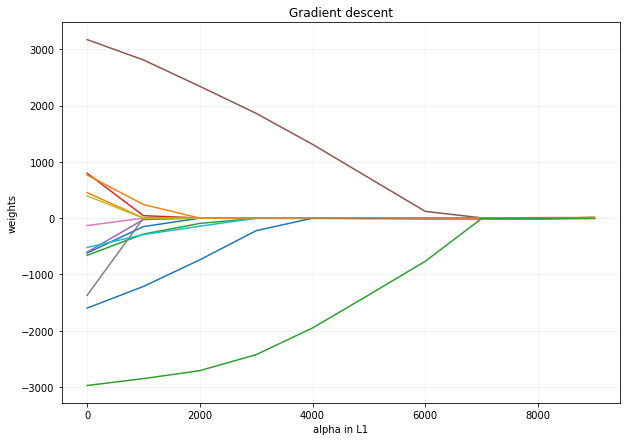

In [35]:
ans = []
alpha_range = range(0, 10000, 1000)
for alpha in alpha_range:
    regr = GradientLR(0.001, iterations=2000, l=alpha, fit_intercept=True)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_val)
    ans.append(regr.w)

ans = pd.DataFrame(ans)
plt.figure(figsize=(10, 7))

for i in range(X.shape[1]):
    
    plt.plot(alpha_range, list(ans.iloc[:, i]))
    plt.title('Gradient descent')
    plt.ylabel('weights')
    plt.xlabel('alpha in L1')
    plt.grid(alpha=0.2)

plt.show()

Здесь все признаки, кроме фиктивной 1. При увеличении коэффициента регуляризации увеличивается штраф за большие веса, и веса постепенно уменьшаются по норме. Явно видно свойство $L1$ регуляризации - она позволяет отбирать признаки по важности. Например при $\alpha = 5000$ веса всего двух признаков не равны 0, эти признаки самые важные (lstat, rm). Далее видно, что всё-таки зеленый признак важнее.


Причина зануления коэффициентов: можно перейти к эквивалентной задаче, где мы минимизируем не loss + кусок от L1, а только loss, на кусок от L1 накладываем ограничение, что он по норме не больше некоторой константы.

Тогда у L1 регуляризации больше шанс попасть в точки, где один из весов равен 0.

In [36]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="http://neerc.ifmo.ru/wiki/images/e/e8/Ridge_and_Lasso_Regression.png")

Однако, в силу того, что градиентный спуск ищет приближённое решение, то веса забитых признаков не в точности равны 0, а колеблются около 0.

In [37]:
regr = GradientLR(0.001, iterations=2000, l=5000, fit_intercept=True)
regr.fit(X_train, y_train)
sorted(list(zip(regr.w, [*X.columns, *['bias weight']])), key=lambda x: abs(x[0]), reverse=True)

[(19462.92504531761, 'bias weight'),
 (-1363.746790247448, 'lstat'),
 (714.7203088106453, 'rm'),
 (-7.4104397408670755, 'nox'),
 (6.441628479321391, 'b'),
 (-6.049764132181042, 'indus'),
 (-4.41384636793631, 'tax'),
 (-2.291650643984015, 'ptratio'),
 (-1.7734705569659446, 'chas'),
 (-1.6253917327062162, 'dis'),
 (-1.452574414058664, 'crim'),
 (-1.3378523131398694, 'rad'),
 (-1.12124960355612, 'zn'),
 (0.7037197078854214, 'age')]

**Мораль работы:**
- Аналитическое решение пытается найти точное решение задачи регрессии, но из-за того, что столбцы признаков могут коррелировать между собой или  кол-во признаков сильно меньше кол-ва строк данных, не всегда есть обратная матрица и нужно использовать псевдообратную.
- Градиентный спуск с L1 регуляризацией решает задачу регрессии итеративно, но в большинстве случаев не точно. Также важен подбор learning rate и regularization coefficient.
- $L1$ регуляризация пытается решить задачу регрессии, используя как можно меньше признаков, поэтому зануляет ненужные.
- Регуляризация помогает градиентному спуску не переобучаться, соответственно улучшая метрики на тестовой выборке. Изначально, без $L1$ регуляризации модель получается переобучена на train выборку, с помощью регуляризации мы снижаем variance и модель "выпрямляется". Но если продолжать увеличивать l1 ratio, то модель начнется пытаться выучить оптимальную закономерность на меньшем числе признаков, это не получится сделать оптимально и она станет недообученной. Это и есть причина выпуклости функции зависимости MSE от l1 ratio.